# Multimodal Housing Classification Pipeline

This notebook implements a multimodal deep learning pipeline to classify housing types based on both image data and tabular features.

Currently it uses an example Hybrid-model, this part will be exchanged for other models.

## Table of Contents

- [Section 1: Setup and Environment](#section-1-setup-and-environment)  
- [Section 2: Data Ingestion](#section-2-data-ingestion)  
- [Section 3: Preprocessing and Splitting](#section-3-preprocessing-and-splitting)  
- [Section 4: Dataset and DataLoader](#section-4-dataset-and-dataloader)  
- [Section 5: Multimodal Model Definition](#section-5-multimodal-model-definition)  
- [Section 6: Training & Validation Functions](#section-6-training--validation-functions)  
- [Section 7: Evaluation & Model Utilities](#section-7-evaluation--model-utilities)  
- [Section 8: Pipeline Execution](#section-8-pipeline-execution)

---

## Section 1: Setup and Environment

- Load necessary libraries for data handling, preprocessing, modeling, and visualization.
- Configure device (GPU/CPU).
- Load environment variables for paths (ensure `.env` file contains `FILE_PATH`).
- Define image directory and CSV data path.

Make sure you have the `.env` file properly configured with the base file path to your dataset and images.


In [1]:
# --- Section 1: Setup ---
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score, 
    log_loss, 
    classification_report, 
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Check for torch.py shadowing
import glob
print("Files named torch.py in current directory:", glob.glob('./torch.py'))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from shapely import wkt
from shapely.affinity import translate, scale

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment and Path Configuration
load_dotenv()
BASE_DIR = os.getenv('FILE_PATH')
if not BASE_DIR:
    raise ValueError("FILE_PATH environment variable not set. Please create a .env file and set it.")

DATA_PATH = os.path.join(BASE_DIR, 'Full_preprocessed_detailed_house.csv')
print(f"Base Directory: {BASE_DIR}")
print(f"Data CSV Path: {DATA_PATH}")


Files named torch.py in current directory: []
Using device: cuda
Base Directory: ../../../Samsung_USB/
Data CSV Path: ../../../Samsung_USB/Full_preprocessed_detailed_house.csv


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

True
1
NVIDIA GeForce RTX 3050 Laptop GPU


## Section 2: Data Ingestion

- Load the dataset CSV file into a DataFrame.
- Print confirmation and dataset shape.


In [3]:
# --- Section 2: Data Ingestion ---
df = pd.read_csv(DATA_PATH)
print("Successfully loaded data. Shape:", df.shape)

def rasterize_polygon(geom, size=224):
    geom = wkt.loads(geom)
    bounds = geom.bounds
    geom = translate(geom, xoff=-bounds[0], yoff=-bounds[1])
    scale_x = size / (bounds[2] - bounds[0] + 1e-8)
    scale_y = size / (bounds[3] - bounds[1] + 1e-8)
    geom = scale(geom, xfact=scale_x, yfact=scale_y, origin=(0, 0))

    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)
    coords = [(x, size - y) for x, y in geom.exterior.coords]
    draw.polygon(coords, outline=1, fill=1)
    return np.array(img)

df["mask"] = df["geometry_wkt"].apply(lambda g: rasterize_polygon(g, size=224))

Successfully loaded data. Shape: (6595, 23)


## Section 3: Preprocessing and Splitting

- Stratified splitting of dataset into train (60%), validation (20%), and test (20%) sets based on the target label (`woningtype`).
- Scale numeric features using training set statistics.
- One-hot encode categorical features using training set statistics.
- Clean and convert features to numeric types and handle missing values.
- Create full image paths and encode target labels with `LabelEncoder`.
- Define final tabular features for the model.


In [4]:
# --- Section 3: Preprocessing and Splitting ---

print(df.dtypes)

print(df['mask'])

def preprocess_tabular_data(train_df, val_df, test_df):
    """Scales numeric columns and one-hot encodes categorical columns."""
    numeric_cols = [ "procent_ingenomen", "area", "perimeter", "elongation",  "compactness"]
    categorical_cols = ['build_type']
    
    # Scale numeric columns based on the training set
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    print("Numeric features scaled.")

    for col in ['centroid_x', 'centroid_y']:
        min_val = train_df[col].min()
        max_val = train_df[col].max()
        for df in [train_df, val_df, test_df]:
            df[col] = (df[col] - min_val) / (max_val - min_val + 1e-8)

    # Ensure these are included in the final list if not already present
    for col in ["huisnr_bag_letter"]:
        if col not in numeric_cols:
            numeric_cols.append(col)

    # One-hot encode categorical columns based on the training set
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(train_df[categorical_cols])
    
    cat_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    def encode_and_merge(df, encoder):
        encoded_data = encoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=cat_encoded_cols, index=df.index)
        return pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    train_df = encode_and_merge(train_df, encoder)
    val_df = encode_and_merge(val_df, encoder)
    test_df = encode_and_merge(test_df, encoder)
    print("Categorical features one-hot encoded.")
    
    return train_df, val_df, test_df, numeric_cols, cat_encoded_cols


def clean_and_convert_features(df, feature_list):
    """Ensures all specified feature columns are numeric, filling NaNs."""
    cleaned_df = df.copy()
    for feature in feature_list:
        if feature in cleaned_df.columns:
            # Convert to numeric, coercing errors to NaN
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            # Fill any resulting NaNs with 0 (or a more suitable value like the mean)
            if cleaned_df[feature].isnull().sum() > 0:
                cleaned_df[feature] = cleaned_df[feature].fillna(0)
            # Ensure final type is float32 for PyTorch
            cleaned_df[feature] = cleaned_df[feature].astype('float32')
    return cleaned_df

def prepare_final_data(df, base_path):
    """Adds the full image path and encodes the 'woningtype' label."""
    # Build full image path
    df['img_path'] = df['frontview_url'].apply(lambda x: os.path.join(base_path, x))
    return df

# 1. Split the original dataframe
print("Splitting data into train (70%), validation (15%), and test (15%)...")
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['woningtype'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['woningtype']) 

# 2. Preprocess tabular data (scaling and encoding)
train_df, val_df, test_df, numeric_cols, cat_encoded_cols = preprocess_tabular_data(train_df, val_df, test_df)

# 3. Define the full list of features for the model
tabular_features = numeric_cols + cat_encoded_cols
print(f"Total tabular features ({len(tabular_features)}): {tabular_features}")

# 4. Clean the dataframes to ensure all feature columns are numeric
print("Cleaning and converting features to numeric types...")
train_df = clean_and_convert_features(train_df, tabular_features)
val_df = clean_and_convert_features(val_df, tabular_features)
test_df = clean_and_convert_features(test_df, tabular_features)

# 5. Create image paths and encode labels
print("Preparing final data (image paths and labels)...")
train_df = prepare_final_data(train_df, BASE_DIR)
val_df = prepare_final_data(val_df, BASE_DIR)
test_df = prepare_final_data(test_df, BASE_DIR)

# Fit LabelEncoder on the full training 'woningtype' to create integer labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['woningtype'])
# Use the same encoder for validation and test sets
val_df['label'] = label_encoder.transform(val_df['woningtype'])
test_df['label'] = label_encoder.transform(test_df['woningtype'])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Number of classes: {len(label_encoder.classes_)}")


print(train_df.dtypes)

woningtype                object
huisnr                     int64
huisnr_bag_letter          int64
huisnr_bag_toevoeging      int64
opp_pand                   int64
build_year                 int64
build_type                object
is_monument                int64
is_protected               int64
geometry                  object
bag_id                     int64
frontview_url             object
procent_ingenomen        float64
geometry_wkt              object
centroid_x               float64
centroid_y               float64
area                     float64
perimeter                float64
compactness              float64
num_vertices               int64
elongation               float64
orientation_deg          float64
num_vertices_log         float64
mask                      object
dtype: object
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3       [[0, 0, 0, 0

## Section 4: Dataset and DataLoader

- Custom PyTorch `Dataset` class loads images and tabular features on-the-fly.
- Applies data augmentations only on training data (random horizontal flips and rotations) (SUBJECT TO CHANGE).
- Uses ImageNet normalization to match pretrained model input expectations.
- DataLoaders created with batch size of 32 and multi-threading support (adjust `NUM_WORKERS` accordingly).

**Notes:**
- You can adjust batch size and transforms to fit your hardware and data augmentation preferences.


In [5]:
# --- Section 4: Dataset and DataLoader ---

class HousingDataset(Dataset):
    def __init__(self, df, transform=None, include_mask=False): # Added include_mask parameter
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.counter = 0
        self.include_mask = include_mask # Store the flag

        print(self.df["mask"].iloc[0])

        # If masks are to be included, check and pre-load them if df["mask"] is available
        if self.include_mask and "mask" in self.df.columns:
            # Assuming df["mask"] contains mask data directly convertible to tensor
            # Masks should ideally be preprocessed into a consistent format (e.g., NumPy arrays)
            # You might need to adjust this based on how your masks are stored in the DataFrame
            self.masks = [torch.tensor(m, dtype=torch.float32).unsqueeze(0) for m in self.df["mask"]]
        elif self.include_mask and "mask" not in self.df.columns:
            print("Warning: include_mask is True, but 'mask' column not found in DataFrame.")
            self.include_mask = False # Disable mask inclusion if data is missing

        self._remove_missing()

    def __len__(self):
        return len(self.df)

    def _remove_missing(self):
        to_drop = []
        for idx, row in self.df.iterrows():
            img_path = row.get('img_path', row.get('frontview_url', None))
            if img_path is None:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row: missing image path')
                continue
            try:
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File not found: {img_path}")
            except Exception as e:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row due to image load error: {e}')

        self.df = self.df.drop(index=to_drop).reset_index(drop=True)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row.get('img_path', row.get('frontview_url', None))
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            
            tabular_data = torch.tensor(row[tabular_features].values.astype(np.float32), dtype=torch.float32)
            label = torch.tensor(row['label'], dtype=torch.long)
            
            if self.include_mask: # Return mask if specified
                mask = self.masks[idx]
                return img, mask, tabular_data, label
            else:
                return img, tabular_data, label
        except Exception as e:
            # print(f"Error loading data at index {idx} (path: {img_path}). Skipping. Error: {e}")
            return self.__getitem__((idx + 1) % len(self)) # Fallback to next item

# ImageNet normalization values, commonly used for pretrained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Add some augmentation (OPTIONEEL)
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# Initialize datasets
train_dataset = HousingDataset(train_df, transform=train_transforms, include_mask=True)
val_dataset = HousingDataset(val_df, transform=val_transforms, include_mask=True)
test_dataset = HousingDataset(test_df, transform=val_transforms, include_mask=True)

# Create DataLoaders
BATCH_SIZE = 32 # Adjusted for common GPU memory sizes, can be tuned
# Set num_workers=0 on Windows or for debugging, can be > 0 on Linux for performance
NUM_WORKERS = 0 if os.name == 'nt' else 2 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Datasets and DataLoaders created successfully.")


[[0 0 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Dropped 1th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0907200000015381-funda.jpg
Dropped 2th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0971200000046451-funda.jpg
Dropped 3th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0935200000040677-funda.jpg
Dropped 4th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0935200000099401-funda.jpg
Dropped 5th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0936200000013023-funda.jpg
Dropped 6th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0938200000022777-funda.jpg
Dropped 7th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000051031-funda.jpg
Dropped 8th row due to image load error:

## Section 5: Multimodal Model Definition

### ZET HIER JE MODEL

### Currently: 
- CNN backbone: ResNet18 pretrained on ImageNet, outputs 512-dim image features.
- Tabular MLP: Two-layer fully connected network with batch normalization and dropout.
- Fusion layer concatenates image and tabular embeddings before final classification head.

**Parameters to tune:**
- `tabular_input_dim`: Number of tabular features.
- Dropout rates and hidden layer sizes can be modified for regularization and capacity.


In [6]:
# --- Section 5: Model Definition ---

class TabularModel(nn.Module):
    """
    MLP for tabular features matching `tabular_emb_dim`.
    """
    def __init__(self, input_dim, emb_dim=128, hidden_dim=256, dropout=0.3):
        super(TabularModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, emb_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_tab):
        return self.mlp(x_tab)

class RandomForestTabular:
    """
    Wrapper for sklearn RandomForestClassifier for tabular fusion.
    """
    def __init__(self, input_dim, num_classes, **kwargs):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, **kwargs)
        self.num_classes = num_classes
        self.is_fitted = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted = True

    def predict_proba(self, X):
        if not self.is_fitted:
            raise RuntimeError("RandomForestTabular must be fitted before calling predict_proba.")
        return self.model.predict_proba(X)

class XGBoostTabular:
    """
    Wrapper for XGBoost XGBClassifier for tabular fusion.
    """
    def __init__(self, input_dim, num_classes, **kwargs):
        self.model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss', **kwargs)
        self.num_classes = num_classes
        self.is_fitted = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted = True

    def predict_proba(self, X):
        if not self.is_fitted:
            raise RuntimeError("XGBoostTabular must be fitted before calling predict_proba.")
        return self.model.predict_proba(X)
    

class ImageModel(nn.Module):
    """
    ResNet18 backbone producing a feature vector of size `cnn_output_dim`.
    """
    def __init__(self, cnn_output_dim=512, pretrained=True):
        super(ImageModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        # drop the final fc layer and avgpool
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.cnn_output_dim = cnn_output_dim

    def forward(self, x_img):
        # x_img: [B,3,H,W]
        feat = self.backbone(x_img)               # [B, cnn_output_dim, 1, 1]
        return feat.view(feat.size(0), self.cnn_output_dim)

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.base_model = models.resnet50(pretrained=pretrained)

        # Remove the final fully connected layer
        self.base_model.fc = nn.Identity()
        self.output_dim = 2048  # This is the output dimension of resnet50 without the fc layer

        # Optionally freeze weights
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)


class EarlyFusionModel(nn.Module):
    """
    Early fusion classifier:
    Args:
        tabular_input_dim (int): number of tabular features
        num_classes (int): number of output classes
        cnn_output_dim (int): image embedding size
        tabular_emb_dim (int): tabular embedding size
        dropout (float): dropout rate
        pretrained (bool): use imagenet weights
    """
    def __init__(self,
                 tabular_input_dim,
                 num_classes,
                 cnn_output_dim=512,
                 tabular_emb_dim=128,
                 dropout=0.5,
                 pretrained=True):
        super(EarlyFusionModel, self).__init__()
        self.img_model = ImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.tab_model = TabularModel(input_dim=tabular_input_dim,
                                      emb_dim=tabular_emb_dim,
                                      hidden_dim=256,
                                      dropout=dropout)
        fusion_dim = cnn_output_dim + tabular_emb_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular_data):
        img_feat = self.img_model(image)
        tab_feat = self.tab_model(tabular_data)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.classifier(fused)

class EarlyFusionRFC(nn.Module):
       def __init__(self, img_model, rfc_tabular, fusion_dim, num_classes):
           super().__init__()
           self.img_model = img_model
           self.rfc_tabular = rfc_tabular
           self.classifier = nn.Sequential(
               nn.Linear(fusion_dim, 256),
               nn.ReLU(),
               nn.Linear(256, num_classes)
           )

       def forward(self, image, tabular_data):
           img_feat = self.img_model(image)
           tab_feats_np = tabular_data.detach().cpu().numpy()
           tab_logits = torch.tensor(self.rfc_tabular.predict_proba(tab_feats_np), dtype=torch.float32, device=image.device)
           fused = torch.cat([img_feat, tab_logits], dim=1)
           return self.classifier(fused)
       

class LateFusionModel(nn.Module):
    """
    Late fusion classifier combining separate heads:
    Args:
        tabular_input_dim (int)
        num_classes (int)
        cnn_output_dim (int)
        tabular_emb_dim (int)
        dropout (float)
        pretrained (bool)
        fusion_method (str): 'concat' or 'weighted'
    """
    def __init__(self,
                 tabular_input_dim,
                 num_classes,
                 cnn_output_dim=512,  # <-- changed from 512 to 2048 for ResNet50
                 tabular_emb_dim=128,
                 dropout=0.5,
                 pretrained=True,
                 fusion_method='concat'):
        super(LateFusionModel, self).__init__()
        # image branch
        self.img_model = ImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.img_clf = nn.Sequential(
            nn.Linear(cnn_output_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        # tabular branch
        self.tab_model = TabularModel(input_dim=tabular_input_dim,
                                      emb_dim=tabular_emb_dim,
                                      hidden_dim=256,
                                      dropout=dropout)
        self.tab_clf = nn.Linear(tabular_emb_dim, num_classes)

        self.fusion_method = fusion_method
        if fusion_method == 'concat':
            self.fusion_clf = nn.Linear(num_classes * 2, num_classes)
        elif fusion_method == 'weighted':
            self.img_w = nn.Parameter(torch.tensor(0.5))
            self.tab_w = nn.Parameter(torch.tensor(0.5))
        else:
            raise ValueError("fusion_method must be 'concat' or 'weighted'")

    def forward(self, image, tabular_data):
        img_feat = self.img_model(image)
        img_logits = self.img_clf(img_feat)

        tab_feat = self.tab_model(tabular_data)
        tab_logits = self.tab_clf(tab_feat)

        if self.fusion_method == 'concat':
            combined = torch.cat([img_logits, tab_logits], dim=1)
            return self.fusion_clf(combined)
        else:
            w_img = torch.sigmoid(self.img_w)
            w_tab = torch.sigmoid(self.tab_w)
            return w_img * img_logits + w_tab * tab_logits
        
class MaskImageModel(nn.Module):
    """
    ResNet18 backbone that optionally takes a mask, multiplies it with the image,
    and produces a feature vector.
    """
    def __init__(self, cnn_output_dim=512, pretrained=True):
        super(MaskImageModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        
        # Modify the first conv layer if you want to concatenate mask as a channel
        # For simplicity, here we assume mask is applied to RGB before passing to ResNet
        # Or, if you want to process mask separately and combine features:
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        # If you want to accept a 4-channel input (RGB + Mask)
        # self.backbone[0] = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.cnn_output_dim = cnn_output_dim

    def forward(self, x_img, x_mask=None):
        # x_img: [B,3,H,W], x_mask: [B,1,H,W]
        
        # Option 1: Apply mask directly to the image (element-wise multiplication)
        if x_mask is not None:
            # Ensure mask is broadcastable to image channels
            x_img = x_img * x_mask # Mask should be 0-1, so it gates the image
        
        feat = self.backbone(x_img) # [B, cnn_output_dim, 1, 1]
        return feat.view(feat.size(0), self.cnn_output_dim)

class MaskMultimodal(nn.Module):
    """
    Multimodal model incorporating image, mask, and tabular data.
    Image features are extracted with an optional mask application,
    tabular features with an MLP, and then concatenated for a final classifier.
    """
    def __init__(self,
                 tabular_input_dim,
                 num_classes,
                 cnn_output_dim=512, # From MaskImageModel (e.g., ResNet18)
                 tabular_emb_dim=128,
                 dropout=0.5,
                 pretrained=True):
        super(MaskMultimodal, self).__init__()

        self.frontview_image_model = ImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.image_model = MaskImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.tabular_model = TabularModel(input_dim=tabular_input_dim,
                                          emb_dim=tabular_emb_dim,
                                          hidden_dim=256,
                                          dropout=dropout)
        
        # fusion_dim includes both image features, plus tabular features
        fusion_dim = cnn_output_dim + cnn_output_dim + tabular_emb_dim
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, mask, tabular_data):
        frontview_img_feat = self.frontview_image_model(image)
        img_feat = self.image_model(image, mask)
        tab_feat = self.tabular_model(tabular_data)
        
        fused = torch.cat([frontview_img_feat, img_feat, tab_feat], dim=1)
        return self.classifier(fused)
    
class PretrainedBackboneWrapper(nn.Module):
    def __init__(self, pretrained_weights_path=None, freeze=True):
        super().__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.base_model.fc = nn.Identity()  # Remove classifier

        if pretrained_weights_path:
            print(f"Loading pretrained weights from: {pretrained_weights_path}")
            state_dict = torch.load(pretrained_weights_path, map_location='cpu')
            self.base_model.load_state_dict(state_dict, strict=False)

        if freeze:
            for param in self.base_model.parameters():
                param.requires_grad = False

        self.output_dim = 2048

    def forward(self, x):
        return self.base_model(x)


class MaskMultimodalWithPretrained(nn.Module):
    def __init__(self, tabular_input_dim, num_classes, 
                 tabular_emb_dim=128, dropout=0.5,
                 pretrained_backbone_path=None):
        super().__init__()

        self.frontview_image_model = PretrainedBackboneWrapper(
            pretrained_weights_path=pretrained_backbone_path,
            freeze=True
        )
        self.masked_image_model = PretrainedBackboneWrapper(
            pretrained_weights_path=pretrained_backbone_path,
            freeze=True
        )

        self.tabular_model = nn.Sequential(
            nn.Linear(tabular_input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, tabular_emb_dim),
            nn.ReLU()
        )

        fusion_dim = 2048 + 2048 + tabular_emb_dim

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, mask, tabular_data):
        masked_image = image * mask  # Apply mask directly
        frontview_features = self.frontview_image_model(image)
        masked_features = self.masked_image_model(masked_image)
        tabular_features = self.tabular_model(tabular_data)
        fused = torch.cat([frontview_features, masked_features, tabular_features], dim=1)
        return self.classifier(fused)

## Section 6: Training & Validation Functions

This section defines functions for performing one epoch of training and validation for the multimodal model.

- **train_one_epoch**:  
  Executes a single epoch of training. The model is set to training mode.  
  For each batch:
  - Data is moved to the specified device (CPU/GPU).
  - Forward pass is performed to compute outputs.
  - Cross-entropy loss is computed and backpropagated.
  - Model parameters are updated via the optimizer.
  - Running loss and predictions are tracked for metrics calculation.
  
  Returns the average loss, accuracy, and weighted F1 score over the entire training dataset for the epoch.

- **validate_one_epoch**:  
  Executes a single epoch of validation without updating model parameters. The model is set to evaluation mode and gradient calculations are disabled.  
  For each batch:
  - Data is moved to the device.
  - Forward pass is performed and loss computed.
  - Predictions and losses are collected.
  
  Returns the average loss, accuracy, and weighted F1 score over the validation dataset.

In [7]:
# --- Section 6: Training & Validation Functions ---

def train_one_epoch(model, dataloader, optimizer, criterion, device, model_type):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch_data in loop:
        if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
            images, masks, tabular_data, labels = batch_data
            images, masks, tabular_data, labels = images.to(device), masks.to(device), tabular_data.to(device), labels.to(device)
            outputs = model(images, masks, tabular_data)
        else:
            # Handle case where dataset includes masks but model doesn't use them
            if len(batch_data) == 4:
                images, masks, tabular_data, labels = batch_data  # Unpack all 4, ignore masks
            else:
                images, tabular_data, labels = batch_data
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
            outputs = model(images, tabular_data)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device, model_type):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch_data in loop:
            if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
                images, masks, tabular_data, labels = batch_data
                images, masks, tabular_data, labels = images.to(device), masks.to(device), tabular_data.to(device), labels.to(device)
                outputs = model(images, masks, tabular_data)
            else:
                # Handle case where dataset includes masks but model doesn't use them
                if len(batch_data) == 4:
                    images, masks, tabular_data, labels = batch_data  # Unpack all 4, ignore masks
                else:
                    images, tabular_data, labels = batch_data
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
                outputs = model(images, tabular_data)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

## Section 7: Evaluation & Model Utilities

This section contains utility functions for evaluating the model’s performance, saving, and loading the model weights.

- **evaluate_model**:  
  Runs inference on a dataset and prints a detailed classification report along with a confusion matrix heatmap to visualize performance across classes.

- **save_model**:  
  Saves the model’s state dictionary to a `models/` directory. If the directory does not exist, it will be created automatically.  
  To avoid overwriting, if a model file with the given name already exists, a numeric suffix (`_1`, `_2`, etc.) is appended to the filename.

- **load_model**:  
  Loads the saved model weights from a specified path, moves the model to the appropriate device (CPU or GPU), and sets it to evaluation mode.


In [8]:
# --- Section 7: Evaluation & Model Utilities ---

def evaluate_model(model, dataloader, device, class_names, model_type):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_data in dataloader:
            if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
                images, masks, tabular_data, labels = batch_data
                images, masks, tabular_data, labels = images.to(device), masks.to(device), tabular_data.to(device), labels.to(device)
                outputs = model(images, masks, tabular_data)
            else:
                # Handle case where dataset includes masks but model doesn't use them
                if len(batch_data) == 4:
                    images, masks, tabular_data, labels = batch_data  # Unpack all 4, ignore masks
                else:
                    images, tabular_data, labels = batch_data
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
                outputs = model(images, tabular_data)
            
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Individual Metrics ---
    print("\n--- Evaluation Metrics ---")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



def save_model(model, filename='trained_model.pth'):
    models_dir = 'models'
    os.makedirs(models_dir, exist_ok=True)
    base_path = os.path.join(models_dir, filename)

    # If file exists, add suffix
    if os.path.exists(base_path):
        base_name, ext = os.path.splitext(filename)
        suffix = 1
        while True:
            new_filename = f"{base_name}_{suffix}{ext}"
            new_path = os.path.join(models_dir, new_filename)
            if not os.path.exists(new_path):
                base_path = new_path
                break
            suffix += 1

    torch.save(model.state_dict(), base_path)
    print(f"Model saved to {base_path}")
    return base_path



def load_model(model_architecture, path, device):
    model_architecture.load_state_dict(torch.load(path, map_location=device))
    model_architecture.to(device)
    model_architecture.eval()
    print(f"Model loaded from {path} and set to evaluation mode.")
    return model_architecture

## Section 8: Pipeline Execution

- Initialize model, criterion (cross entropy), and optimizer (Adam). (SUBJECT TO CHANGE)
- Run training/validation for specified epochs.
- Save best model weights.
- Load best model for final testing and evaluation.

**User Options:**
- Modify `NUM_EPOCHS`, learning rate (`lr`), and batch size (`BATCH_SIZE`) to fit your needs.
- You can replace `MultimodalHousingClassifier` with your custom model if desired.


🚀 Starting full pipeline execution...
Loading pretrained weights from: ../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth


C:\Users\Matth\AppData\Local\Temp\ipykernel_31800\2232089938.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights_path, map_locat

Loading pretrained weights from: ../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth
Model initialized with 1,121,162 trainable parameters.
Training for 5 epochs...

--- Epoch 1/5 ---


Epoch 1 Summary:
  Train -> Loss: 1.7442, Acc: 0.3757, F1: 0.3694
  Valid -> Loss: 1.3760, Acc: 0.5183, F1: 0.5087
Model saved to models\best_housing_classifier_66.pth
🎉 New best model saved with F1 score: 0.5087

--- Epoch 2/5 ---


Epoch 2 Summary:
  Train -> Loss: 1.2751, Acc: 0.5520, F1: 0.5411
  Valid -> Loss: 1.1938, Acc: 0.5804, F1: 0.5599
Model saved to models\best_housing_classifier_67.pth
🎉 New best model saved with F1 score: 0.5599

--- Epoch 3/5 ---


Epoch 3 Summary:
  Train -> Loss: 1.1294, Acc: 0.5986, F1: 0.5900
  Valid -> Loss: 1.1269, Acc: 0.6130, F1: 0.5942
Model saved to models\best_housing_classifier_68.pth
🎉 New best model saved with F1 score: 0.5942

--- Epoch 4/5 ---


Epoch 4 Summary:
  Train -> Loss: 1.0436, Acc: 0.6256, F1: 0.6177
  Valid -> Loss: 1.0904, Acc: 0.6141, F1: 0.6046
Model saved to models\best_housing_classifier_69.pth
🎉 New best model saved with F1 score: 0.6046

--- Epoch 5/5 ---


Epoch 5 Summary:
  Train -> Loss: 0.9986, Acc: 0.6378, F1: 0.6307
  Valid -> Loss: 1.0980, Acc: 0.6202, F1: 0.6107
Model saved to models\best_housing_classifier_70.pth
🎉 New best model saved with F1 score: 0.6107

✅ Training complete.

📊 Loading best model from 'models\best_housing_classifier_70.pth' and evaluating on the test set...
Loading pretrained weights from: ../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth


C:\Users\Matth\AppData\Local\Temp\ipykernel_31800\2232089938.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights_path, map_locat

Loading pretrained weights from: ../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth


C:\Users\Matth\AppData\Local\Temp\ipykernel_31800\2650379550.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(path, map_loc

Model loaded from models\best_housing_classifier_70.pth and set to evaluation mode.

--- Evaluation Metrics ---
Accuracy: 0.6121
Precision (macro): 0.5982
Recall (macro): 0.6035
F1 Score (macro): 0.5959
Cohen's Kappa: 0.5594
Log Loss: 1.0723

--- Classification Report ---
                                      precision    recall  f1-score   support

                 2-onder-1-kapwoning       0.59      0.57      0.58        69
Bovenwoning/Benedenwoning/Maisonette       0.63      0.57      0.60       197
            Corridorflat/Galerijflat       0.56      0.48      0.52        91
     Geschakelde 2-onder-1-kapwoning       0.61      0.72      0.66        69
                  Geschakelde woning       0.44      0.34      0.39        70
              Halfvrijstaande woning       0.39      0.24      0.30        67
               Hoekwoning/Eindwoning       0.74      0.81      0.77       142
           Portiekflat/Portiekwoning       0.48      0.60      0.53       131
                        

C:\Users\Matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


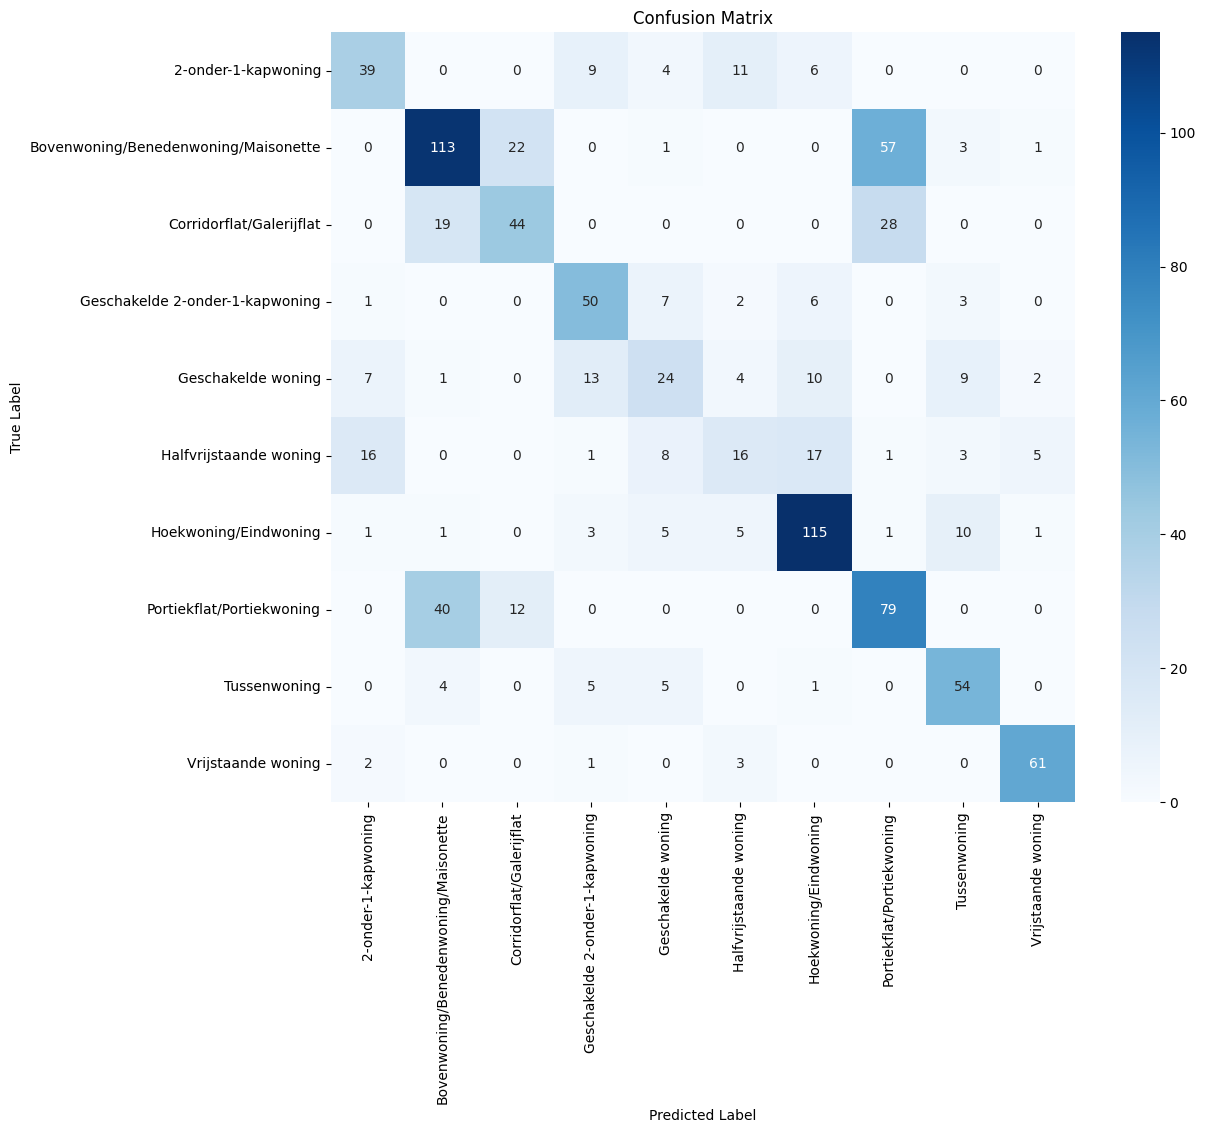


✅ Pipeline finished successfully!


In [9]:
# --- Section 8: Main Pipeline Execution ---

print("🚀 Starting full pipeline execution...")

model_names = ['EarlyFusionModel', 'LateFusionModel', 'EarlyFusionRFC', 'MultiMask', 'MaskMultimodalWithPretrained']
chosen_model = 'MaskMultimodalWithPretrained'  # Set to 'MultiMask' to test the new model

pretraining_weights_pathenings = "../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth"

# 1. Initialize Model
tabular_input_dim = len(tabular_features)
num_classes = len(label_encoder.classes_)

# Example for Random Forest fusion:
rfc_tabular = RandomForestTabular(input_dim=tabular_input_dim, num_classes=num_classes)
rfc_tabular.fit(train_df[tabular_features].values, train_df['label'].values)
img_model = ImageModel(cnn_output_dim=512, pretrained=True)
fusion_dim = 512 + num_classes

if chosen_model == 'EarlyFusionModel':
    model = EarlyFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device)
elif chosen_model == 'LateFusionModel':
    model = LateFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes, cnn_output_dim=2048).to(device)
elif chosen_model == 'EarlyFusionRFC':
    model = EarlyFusionRFC(img_model=img_model, rfc_tabular=rfc_tabular, fusion_dim=fusion_dim, num_classes=num_classes).to(device)
elif chosen_model == 'MultiMask':
    model = MaskMultimodal(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device) # Instantiate your new model
elif chosen_model == 'MaskMultimodalWithPretrained':
    model = MaskMultimodalWithPretrained(tabular_input_dim=tabular_input_dim, num_classes=num_classes, pretrained_backbone_path="../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth").to(device)
else:
    raise ValueError(f"Unknown model type: {chosen_model}")

print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

# 2. Define Loss, Optimizer, and Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
NUM_EPOCHS = 5
best_val_f1 = 0
BEST_MODEL_PATH = "best_housing_classifier.pth"

print(f"Training for {NUM_EPOCHS} epochs...")

# 3. Run Training and Validation Loop
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
    
    # Pass `chosen_model` (or a string 'MultiMask') to the training/train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, chosen_model)validation functions
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, chosen_model)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, criterion, device, chosen_model)

    print(f"Epoch {epoch} Summary:")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        model_path = save_model(model, BEST_MODEL_PATH)
        print(f"🎉 New best model saved with F1 score: {best_val_f1:.4f}")

print("\n✅ Training complete.")

# 4. Evaluate the Best Model on the Test Set
print(f"\n📊 Loading best model from '{model_path}' and evaluating on the test set...")
# Re-initialize a fresh model architecture for loading
if chosen_model == 'EarlyFusionModel':
    final_model = EarlyFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device)
elif chosen_model == 'LateFusionModel':
    final_model = LateFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes, cnn_output_dim=2048).to(device)
elif chosen_model == 'EarlyFusionRFC':
    final_model = EarlyFusionRFC(img_model=img_model, rfc_tabular=rfc_tabular, fusion_dim=fusion_dim, num_classes=num_classes).to(device)
elif chosen_model == 'MultiMask':
    final_model = MaskMultimodal(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device)
elif chosen_model == 'MaskMultimodalWithPretrained':
    final_model = MaskMultimodalWithPretrained(tabular_input_dim=tabular_input_dim, num_classes=num_classes, pretrained_backbone_path="../Model Architecture/models/resnet50_ssl_pretrained_backbone2.pth").to(device)

final_model = load_model(final_model, model_path, device)

class_names = list(label_encoder.classes_)
# Pass the model_type to evaluation function as well
evaluate_model(final_model, test_loader, device, class_names=class_names, model_type=chosen_model)

print("\n✅ Pipeline finished successfully!")

## Section 9: Feature Importance Visualization

This section implements comprehensive feature importance analysis for the multimodal model including:

- **Tabular Feature Importance**: Gradient-based importance and permutation importance
- **Image Feature Importance**: Grad-CAM visualization and integrated gradients  
- **Mask Attention Analysis**: Understanding how the mask affects predictions
- **Multimodal Fusion Analysis**: Contribution of different modalities

The visualizations help understand:
1. Which tabular features are most important for predictions
2. Which image regions the model focuses on
3. How the mask influences the model's attention
4. The relative importance of different data modalities

In [10]:
# --- Section 9: Feature Importance Analysis ---

# Additional imports for feature importance visualization
import cv2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
warnings.filterwarnings('ignore')

# Install captum for gradient-based explanations if not already installed
# !pip install captum

try:
    from captum.attr import IntegratedGradients, GradientShap, GradCam, LayerGradCam
    from captum.metrics import infidelity, sensitivity_max
    CAPTUM_AVAILABLE = True
    print("✅ Captum library loaded successfully")
except ImportError:
    print("⚠️ Captum not available. Install with: pip install captum")
    CAPTUM_AVAILABLE = False

class ModelWrapper(BaseEstimator, ClassifierMixin):
    """Sklearn-compatible wrapper for PyTorch multimodal model to enable permutation importance"""
    
    def __init__(self, model, device, model_type='MultiMask'):
        self.model = model
        self.device = device
        self.model_type = model_type
        self.classes_ = None
        
    def fit(self, X, y):
        # This wrapper doesn't actually train, just stores class info
        self.classes_ = np.unique(y)
        return self
        
    def predict_proba(self, X_combined):
        """
        X_combined: tuple of (images, masks, tabular_data) for MultiMask
        or (images, tabular_data) for other models
        """
        self.model.eval()
        with torch.no_grad():
            if self.model_type == 'MultiMask' or self.model_type == 'MaskMultimodalWithPretrained':
                images, masks, tabular_data = X_combined
                images = torch.tensor(images, dtype=torch.float32).to(self.device)
                masks = torch.tensor(masks, dtype=torch.float32).to(self.device)
                tabular_data = torch.tensor(tabular_data, dtype=torch.float32).to(self.device)
                outputs = self.model(images, masks, tabular_data)
            else:
                images, tabular_data = X_combined
                images = torch.tensor(images, dtype=torch.float32).to(self.device)
                tabular_data = torch.tensor(tabular_data, dtype=torch.float32).to(self.device)
                outputs = self.model(images, tabular_data)
            
            return torch.softmax(outputs, dim=1).cpu().numpy()
    
    def predict(self, X_combined):
        proba = self.predict_proba(X_combined)
        return np.argmax(proba, axis=1)

def get_sample_batch(dataloader, batch_size=8):
    """Get a sample batch for analysis"""
    for batch in dataloader:
        if len(batch) == 4:  # MultiMask model
            images, masks, tabular_data, labels = batch
            return (images[:batch_size], masks[:batch_size], 
                   tabular_data[:batch_size], labels[:batch_size])
        else:  # Other models
            images, tabular_data, labels = batch
            return images[:batch_size], tabular_data[:batch_size], labels[:batch_size]

print("🔧 Feature importance utilities loaded successfully")

⚠️ Captum not available. Install with: pip install captum
🔧 Feature importance utilities loaded successfully


In [11]:
def analyze_tabular_feature_importance(model, test_loader, tabular_features, device, model_type='MultiMask', n_samples=100):
    """
    Analyze tabular feature importance using gradient-based methods and permutation importance
    """
    print("🔍 Analyzing tabular feature importance...")
    
    # Get sample data for analysis
    sample_batch = get_sample_batch(test_loader, batch_size=min(n_samples, 32))
    
    if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
        sample_images, sample_masks, sample_tabular, sample_labels = sample_batch
        X_combined = (sample_images.numpy(), sample_masks.numpy(), sample_tabular.numpy())
    else:
        sample_images, sample_tabular, sample_labels = sample_batch
        X_combined = (sample_images.numpy(), sample_tabular.numpy())
    
    y_true = sample_labels.numpy()
    
    # Create model wrapper for sklearn compatibility
    model_wrapper = ModelWrapper(model, device, model_type)
    model_wrapper.fit(X_combined[2] if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained' else X_combined[1], y_true)
    
    # Custom scoring function for permutation importance
    def custom_score(X_combined, y_true):
        predictions = model_wrapper.predict(X_combined)
        return accuracy_score(y_true, predictions)
    
    # Gradient-based feature importance
    print("  📊 Computing gradient-based importance...")
    model.eval()
    model.zero_grad()
    
    if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
        images = sample_images.to(device).requires_grad_(True)
        masks = sample_masks.to(device)
        tabular = sample_tabular.to(device).requires_grad_(True)
        outputs = model(images, masks, tabular)
    else:
        images = sample_images.to(device)
        tabular = sample_tabular.to(device).requires_grad_(True)
        outputs = model(images, tabular)
    
    # Get predictions and compute gradients
    preds = torch.argmax(outputs, dim=1)
    loss = criterion(outputs, preds)
    loss.backward()
    
    # Extract gradients for tabular features
    if tabular.grad is not None:
        grad_importance = torch.abs(tabular.grad).mean(dim=0).cpu().numpy()
    else:
        grad_importance = np.zeros(len(tabular_features))
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Gradient-based importance
    feature_names = [f.replace('_', ' ').title() for f in tabular_features]
    ax1.barh(range(len(grad_importance)), grad_importance)
    ax1.set_yticks(range(len(feature_names)))
    ax1.set_yticklabels(feature_names, fontsize=8)
    ax1.set_xlabel('Gradient Magnitude')
    ax1.set_title('Gradient-based Feature Importance')
    ax1.grid(alpha=0.3)
    
    # 2. Top 10 most important features
    top_indices = np.argsort(grad_importance)[-10:]
    ax2.barh(range(len(top_indices)), grad_importance[top_indices])
    ax2.set_yticks(range(len(top_indices)))
    ax2.set_yticklabels([feature_names[i] for i in top_indices], fontsize=10)
    ax2.set_xlabel('Gradient Magnitude')
    ax2.set_title('Top 10 Most Important Features')
    ax2.grid(alpha=0.3)
    
    # 3. Feature importance distribution
    ax3.hist(grad_importance, bins=20, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Gradient Magnitude')
    ax3.set_ylabel('Number of Features')
    ax3.set_title('Distribution of Feature Importance')
    ax3.grid(alpha=0.3)
    
    # 4. Normalized feature importance (top 15)
    top_15_indices = np.argsort(grad_importance)[-15:]
    normalized_importance = grad_importance[top_15_indices] / np.sum(grad_importance[top_15_indices])
    
    ax4.pie(normalized_importance, labels=[feature_names[i][:15] + '...' if len(feature_names[i]) > 15 
                                          else feature_names[i] for i in top_15_indices], 
            autopct='%1.1f%%', startangle=90)
    ax4.set_title('Top 15 Features - Relative Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\\n📈 Top 10 Most Important Features:")
    for i, idx in enumerate(top_indices[-10:][::-1]):
        print(f"  {i+1:2d}. {feature_names[idx]}: {grad_importance[idx]:.6f}")
    
    return grad_importance, feature_names

print("📊 Tabular feature importance analysis functions loaded")

📊 Tabular feature importance analysis functions loaded


In [12]:
def visualize_image_attention(model, sample_images, sample_masks, sample_tabular, 
                             sample_labels, device, model_type='MultiMask', n_samples=4):
    """
    Visualize image attention using Grad-CAM and integrated gradients
    """
    print("🖼️ Analyzing image attention and feature importance...")
    
    if not CAPTUM_AVAILABLE:
        print("⚠️ Captum not available. Skipping advanced image analysis.")
        return simple_image_gradients(model, sample_images, sample_masks, sample_tabular, device, model_type)
    
    model.eval()
    n_samples = min(n_samples, len(sample_images))
    
    # Define wrapper function for image input only
    def model_wrapper_img(images):
        if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
            return model(images, sample_masks[:images.shape[0]].to(device), 
                        sample_tabular[:images.shape[0]].to(device))
        else:
            return model(images, sample_tabular[:images.shape[0]].to(device))
    
    # Initialize attribution methods
    ig = IntegratedGradients(model_wrapper_img)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_samples):
        img = sample_images[i:i+1].to(device)
        label = sample_labels[i].item()
        
        # Original image
        orig_img = sample_images[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
        orig_img = np.clip(orig_img, 0, 1)
        
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original Image\\nTrue Label: {class_names[label]}')
        axes[i, 0].axis('off')
        
        # Mask if available
        if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
            mask_img = sample_masks[i].squeeze().numpy()
            axes[i, 1].imshow(mask_img, cmap='gray')
            axes[i, 1].set_title('Mask')
            axes[i, 1].axis('off')
        else:
            axes[i, 1].axis('off')
            axes[i, 1].set_title('No Mask')
        
        # Integrated gradients
        try:
            attributions_ig = ig.attribute(img, target=label, n_steps=50)
            attribution_img = attributions_ig.squeeze().cpu().detach().numpy()
            attribution_img = np.transpose(attribution_img, (1, 2, 0))
            attribution_magnitude = np.sqrt(np.sum(attribution_img**2, axis=2))
            
            im = axes[i, 2].imshow(attribution_magnitude, cmap='hot', alpha=0.7)
            axes[i, 2].imshow(orig_img, alpha=0.3)
            axes[i, 2].set_title('Integrated Gradients\\nAttention Map')
            axes[i, 2].axis('off')
            plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)
            
        except Exception as e:
            print(f"Error computing integrated gradients for sample {i}: {e}")
            axes[i, 2].text(0.5, 0.5, 'Attribution\\nError', ha='center', va='center', 
                           transform=axes[i, 2].transAxes, fontsize=12)
            axes[i, 2].axis('off')
        
        # Simple gradient
        img_grad = compute_image_gradients(model, img, sample_masks[i:i+1] if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained' else None,
                                         sample_tabular[i:i+1], label, device, model_type)
        
        axes[i, 3].imshow(img_grad, cmap='hot', alpha=0.7)
        axes[i, 3].imshow(orig_img, alpha=0.3)
        axes[i, 3].set_title('Gradient-based\\nAttention')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return True

def compute_image_gradients(model, image, mask, tabular, target_class, device, model_type):
    """Compute gradients with respect to input image"""
    model.eval()
    image.requires_grad_(True)
    
    if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
        output = model(image, mask.to(device), tabular.to(device))
    else:
        output = model(image, tabular.to(device))
    
    # Get the score for the target class
    target_score = output[0, target_class]
    
    # Compute gradients
    model.zero_grad()
    target_score.backward()
    
    # Process gradients
    gradients = image.grad.data.abs()
    gradients = gradients.squeeze().cpu().numpy()
    
    # Average across color channels and normalize
    if len(gradients.shape) == 3:
        gradients = np.mean(gradients, axis=0)
    
    # Normalize to [0, 1]
    if gradients.max() > gradients.min():
        gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    
    return gradients

def simple_image_gradients(model, sample_images, sample_masks, sample_tabular, device, model_type, n_samples=4):
    """Simple gradient-based visualization when Captum is not available"""
    print("📸 Using simple gradient-based image analysis...")
    
    model.eval()
    n_samples = min(n_samples, len(sample_images))
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_samples):
        img = sample_images[i:i+1].to(device)
        label = sample_labels[i].item()
        
        # Original image
        orig_img = sample_images[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
        orig_img = np.clip(orig_img, 0, 1)
        
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original Image\\nLabel: {class_names[label]}')
        axes[i, 0].axis('off')
        
        # Mask if available
        if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained':
            mask_img = sample_masks[i].squeeze().numpy()
            axes[i, 1].imshow(mask_img, cmap='gray')
            axes[i, 1].set_title('Mask')
            axes[i, 1].axis('off')
        else:
            axes[i, 1].axis('off')
        
        # Gradient visualization
        img_grad = compute_image_gradients(model, img, 
                                         sample_masks[i:i+1] if model_type == 'MultiMask' or model_type == 'MaskMultimodalWithPretrained' else None,
                                         sample_tabular[i:i+1], label, device, model_type)
        
        axes[i, 2].imshow(img_grad, cmap='hot')
        axes[i, 2].set_title('Gradient Attention')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return True

print("🖼️ Image attention visualization functions loaded")

🖼️ Image attention visualization functions loaded


In [17]:
def analyze_multimodal_fusion(model, test_loader, device, model_type='MultiMask', n_samples=100):
    """
    Analyze the contribution of different modalities to the final prediction
    """
    print("🔗 Analyzing multimodal fusion importance...")
    
    if model_type != 'MultiMask' and model_type != 'MaskMultimodalWithPretrained':
        print("⚠️ Multimodal fusion analysis currently only supports MaskMultimodal models")
        return
    
    model.eval()
    sample_batch = get_sample_batch(test_loader, batch_size=n_samples)
    sample_images, sample_masks, sample_tabular, sample_labels = sample_batch
    
    # Move to device
    sample_images = sample_images.to(device)
    sample_masks = sample_masks.to(device)
    sample_tabular = sample_tabular.to(device)
    sample_labels = sample_labels.to(device)
    
    # Get original predictions
    with torch.no_grad():
        original_outputs = model(sample_images, sample_masks, sample_tabular)
        original_probs = torch.softmax(original_outputs, dim=1)
        original_preds = torch.argmax(original_probs, dim=1)
    
    # Analyze contribution by zeroing out different modalities
    results = {}
    
    # Get features based on model type
    print("  🖼️ Testing without frontview image features...")
    with torch.no_grad():
        frontview_feat = model.frontview_image_model(sample_images)
        
        if model_type == 'MaskMultimodalWithPretrained':
            # For MaskMultimodalWithPretrained, apply mask to image first
            masked_image = sample_images * sample_masks
            img_feat = model.masked_image_model(masked_image)
        else:
            # For MultiMask, use the mask-aware forward pass
            img_feat = model.image_model(sample_images, sample_masks)
        
        tab_feat = model.tabular_model(sample_tabular)
        
        # Zero out frontview features
        frontview_feat_zero = torch.zeros_like(frontview_feat)
        fused_no_frontview = torch.cat([frontview_feat_zero, img_feat, tab_feat], dim=1)
        outputs_no_frontview = model.classifier(fused_no_frontview)
        probs_no_frontview = torch.softmax(outputs_no_frontview, dim=1)
    
    # 2. Without masked image
    print("  🎭 Testing without masked image features...")
    with torch.no_grad():
        img_feat_zero = torch.zeros_like(img_feat)
        fused_no_mask = torch.cat([frontview_feat, img_feat_zero, tab_feat], dim=1)
        outputs_no_mask = model.classifier(fused_no_mask)
        probs_no_mask = torch.softmax(outputs_no_mask, dim=1)
    
    # 3. Without tabular data
    print("  📊 Testing without tabular features...")
    with torch.no_grad():
        tab_feat_zero = torch.zeros_like(tab_feat)
        fused_no_tab = torch.cat([frontview_feat, img_feat, tab_feat_zero], dim=1)
        outputs_no_tab = model.classifier(fused_no_tab)
        probs_no_tab = torch.softmax(outputs_no_tab, dim=1)
    
    # Calculate performance drops
    def calculate_accuracy_drop(original_preds, modified_probs, labels):
        modified_preds = torch.argmax(modified_probs, dim=1)
        original_acc = (original_preds == labels).float().mean().item()
        modified_acc = (modified_preds == labels).float().mean().item()
        return original_acc - modified_acc
    
    acc_drop_no_frontview = calculate_accuracy_drop(original_preds, probs_no_frontview, sample_labels)
    acc_drop_no_mask = calculate_accuracy_drop(original_preds, probs_no_mask, sample_labels)
    acc_drop_no_tab = calculate_accuracy_drop(original_preds, probs_no_tab, sample_labels)
    
    # Calculate prediction confidence changes
    original_confidence = torch.max(original_probs, dim=1)[0].mean().item()
    conf_no_frontview = torch.max(probs_no_frontview, dim=1)[0].mean().item()
    conf_no_mask = torch.max(probs_no_mask, dim=1)[0].mean().item()
    conf_no_tab = torch.max(probs_no_tab, dim=1)[0].mean().item()
    
    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Accuracy drops
    modalities = ['Frontview\\nImage', 'Masked\\nImage', 'Tabular\\nData']
    acc_drops = [acc_drop_no_frontview, acc_drop_no_mask, acc_drop_no_tab]
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars1 = ax1.bar(modalities, acc_drops, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Accuracy Drop')
    ax1.set_title('Modality Importance by Accuracy Drop')
    ax1.grid(alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars1, acc_drops):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Confidence changes
    confidences = [original_confidence, conf_no_frontview, conf_no_mask, conf_no_tab]
    labels_conf = ['Original', 'No Frontview', 'No Masked', 'No Tabular']
    
    ax2.plot(labels_conf, confidences, marker='o', linewidth=2, markersize=8)
    ax2.set_ylabel('Prediction Confidence')
    ax2.set_title('Confidence Changes by Modality Removal')
    ax2.grid(alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Relative importance pie chart
    total_importance = sum(acc_drops)
    if total_importance > 0:
        relative_importance = [drop/total_importance for drop in acc_drops]
        ax3.pie(relative_importance, labels=modalities, autopct='%1.1f%%', 
               colors=colors, startangle=90)
        ax3.set_title('Relative Modality Importance')
    else:
        ax3.text(0.5, 0.5, 'No significant\\ndifferences detected', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Relative Modality Importance')
    
    # 4. Feature magnitude comparison
    with torch.no_grad():
        frontview_magnitude = torch.norm(frontview_feat, dim=1).mean().item()
        mask_magnitude = torch.norm(img_feat, dim=1).mean().item()
        tabular_magnitude = torch.norm(tab_feat, dim=1).mean().item()
    
    magnitudes = [frontview_magnitude, mask_magnitude, tabular_magnitude]
    bars4 = ax4.bar(modalities, magnitudes, color=colors, alpha=0.7, edgecolor='black')
    ax4.set_ylabel('Feature Magnitude (L2 Norm)')
    ax4.set_title('Feature Magnitude by Modality')
    ax4.grid(alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars4, magnitudes):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(magnitudes)*0.01, 
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\\n📋 Multimodal Fusion Analysis Summary:")
    print(f"  Original Accuracy: {(original_preds == sample_labels).float().mean().item():.3f}")
    print(f"  Original Confidence: {original_confidence:.3f}")
    print("\\n🔍 Importance by Accuracy Drop (higher = more important):")
    print(f"  Frontview Image: {acc_drop_no_frontview:.3f}")
    print(f"  Masked Image: {acc_drop_no_mask:.3f}")
    print(f"  Tabular Data: {acc_drop_no_tab:.3f}")
    
    results = {
        'accuracy_drops': {'frontview': acc_drop_no_frontview, 'masked': acc_drop_no_mask, 'tabular': acc_drop_no_tab},
        'confidences': {'original': original_confidence, 'no_frontview': conf_no_frontview, 
                       'no_masked': conf_no_mask, 'no_tabular': conf_no_tab},
        'feature_magnitudes': {'frontview': frontview_magnitude, 'masked': mask_magnitude, 'tabular': tabular_magnitude}
    }
    
    return results

def analyze_mask_impact(model, test_loader, device, n_samples=50):
    """
    Analyze how the mask affects model predictions
    """
    print("🎭 Analyzing mask impact on predictions...")
    
    model.eval()
    sample_batch = get_sample_batch(test_loader, batch_size=n_samples)
    sample_images, sample_masks, sample_tabular, sample_labels = sample_batch
    
    # Move to device
    sample_images = sample_images.to(device)
    sample_masks = sample_masks.to(device)
    sample_tabular = sample_tabular.to(device)
    sample_labels = sample_labels.to(device)
    
    # Predictions with mask
    with torch.no_grad():
        outputs_with_mask = model(sample_images, sample_masks, sample_tabular)
        probs_with_mask = torch.softmax(outputs_with_mask, dim=1)
        preds_with_mask = torch.argmax(probs_with_mask, dim=1)
    
    # Predictions without mask (mask = ones)
    with torch.no_grad():
        ones_mask = torch.ones_like(sample_masks)
        outputs_no_mask = model(sample_images, ones_mask, sample_tabular)
        probs_no_mask = torch.softmax(outputs_no_mask, dim=1)
        preds_no_mask = torch.argmax(probs_no_mask, dim=1)
    
    # Calculate differences
    prediction_changes = (preds_with_mask != preds_no_mask).sum().item()
    confidence_with_mask = torch.max(probs_with_mask, dim=1)[0]
    confidence_no_mask = torch.max(probs_no_mask, dim=1)[0]
    confidence_diff = (confidence_with_mask - confidence_no_mask).cpu().numpy()
    
    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Prediction changes
    ax1.bar(['With Mask', 'Without Mask'], 
           [(preds_with_mask == sample_labels).sum().item(), 
            (preds_no_mask == sample_labels).sum().item()],
           color=['blue', 'orange'], alpha=0.7)
    ax1.set_ylabel('Correct Predictions')
    ax1.set_title(f'Accuracy Comparison\\n({prediction_changes}/{n_samples} predictions changed)')
    ax1.grid(alpha=0.3)
    
    # 2. Confidence differences
    ax2.hist(confidence_diff, bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='No Change')
    ax2.set_xlabel('Confidence Difference (With - Without Mask)')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Impact of Mask on Prediction Confidence')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Mask coverage vs confidence change
    mask_coverage = sample_masks.mean(dim=[2, 3]).cpu().numpy().flatten()
    ax3.scatter(mask_coverage, confidence_diff, alpha=0.6)
    ax3.set_xlabel('Mask Coverage (proportion of image)')
    ax3.set_ylabel('Confidence Difference')
    ax3.set_title('Mask Coverage vs Confidence Change')
    ax3.grid(alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(mask_coverage, confidence_diff)[0, 1]
    ax3.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
            transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Sample visualizations
    ax4.axis('off')
    ax4.text(0.5, 0.5, f'Mask Impact Summary:\\n\\n' + 
            f'Predictions Changed: {prediction_changes}/{n_samples}\\n' +
            f'Avg Confidence Diff: {confidence_diff.mean():.3f}\\n' +
            f'Mask-Confidence Correlation: {correlation:.3f}',
            ha='center', va='center', transform=ax4.transAxes, 
            fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\\n🎭 Mask Impact Summary:")
    print(f"  Predictions changed: {prediction_changes}/{n_samples} ({100*prediction_changes/n_samples:.1f}%)")
    print(f"  Average confidence difference: {confidence_diff.mean():.3f}")
    print(f"  Mask coverage correlation: {correlation:.3f}")
    
    return {
        'prediction_changes': prediction_changes,
        'confidence_diff': confidence_diff,
        'mask_coverage': mask_coverage,
        'correlation': correlation
    }

print("🔗 Multimodal fusion and mask analysis functions loaded")

🔗 Multimodal fusion and mask analysis functions loaded


🚀 Starting comprehensive feature importance analysis...
📦 Preparing sample data...
✅ Sample batch prepared with 8 samples
\n1️⃣ TABULAR FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
🔍 Analyzing tabular feature importance...
✅ Sample batch prepared with 8 samples
\n1️⃣ TABULAR FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
🔍 Analyzing tabular feature importance...
  📊 Computing gradient-based importance...
  📊 Computing gradient-based importance...


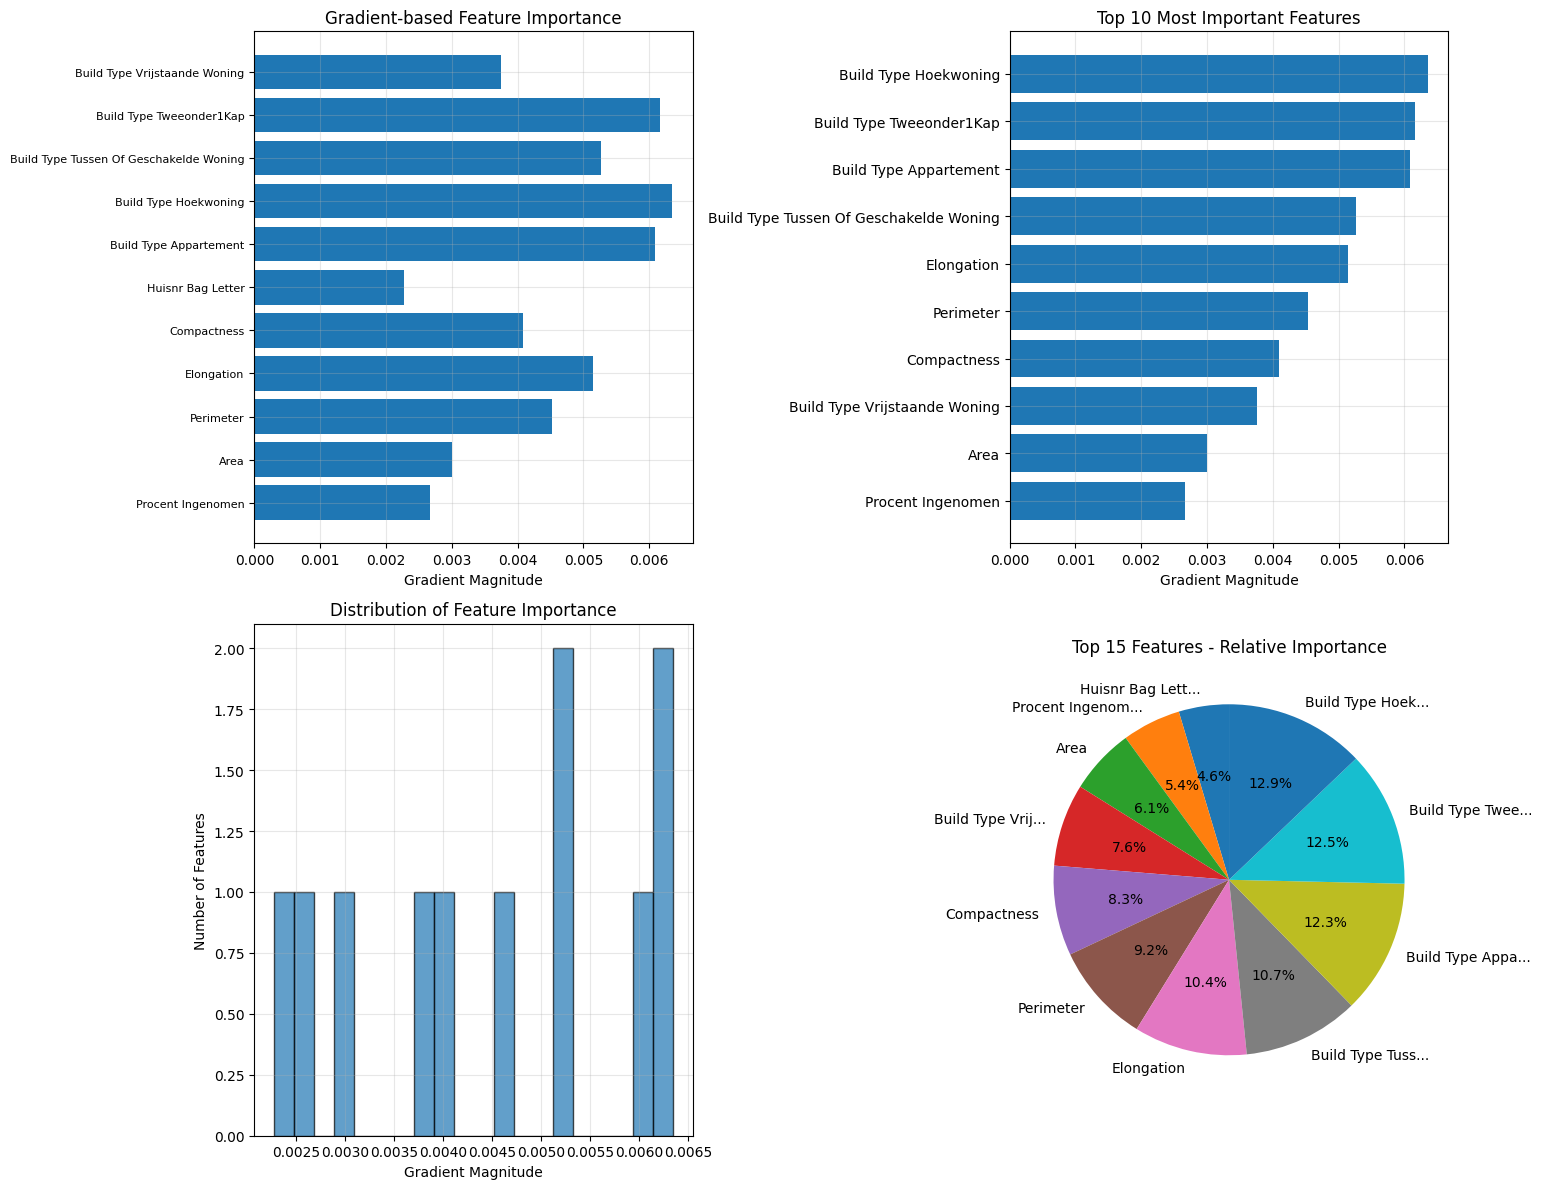

\n📈 Top 10 Most Important Features:
   1. Build Type Hoekwoning: 0.006350
   2. Build Type Tweeonder1Kap: 0.006158
   3. Build Type Appartement: 0.006090
   4. Build Type Tussen Of Geschakelde Woning: 0.005269
   5. Elongation: 0.005147
   6. Perimeter: 0.004530
   7. Compactness: 0.004086
   8. Build Type Vrijstaande Woning: 0.003753
   9. Area: 0.002998
  10. Procent Ingenomen: 0.002667
✅ Tabular feature importance analysis completed
\n2️⃣ IMAGE ATTENTION VISUALIZATION
--------------------------------------------------
🖼️ Analyzing image attention and feature importance...
⚠️ Captum not available. Skipping advanced image analysis.
📸 Using simple gradient-based image analysis...


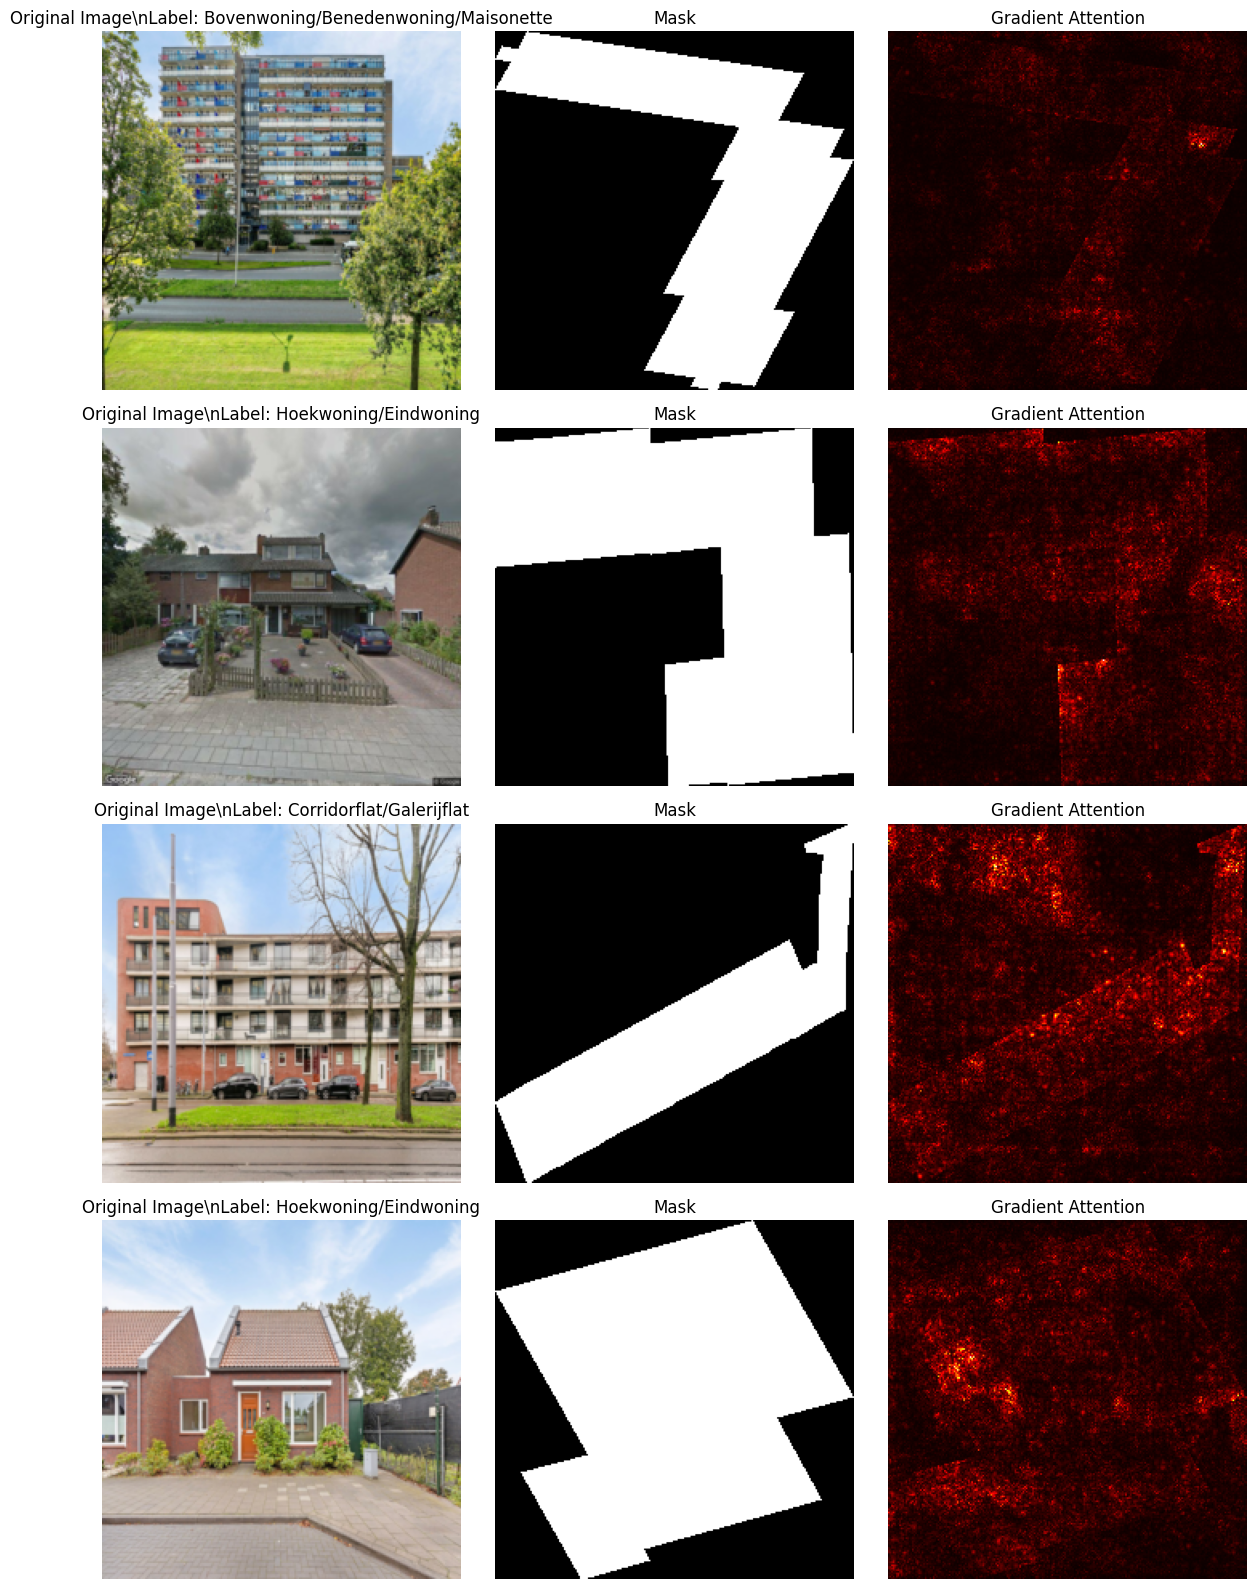

✅ Image attention visualization completed
\n3️⃣ MULTIMODAL FUSION ANALYSIS
--------------------------------------------------
🔗 Analyzing multimodal fusion importance...
  🖼️ Testing without frontview image features...
  🎭 Testing without masked image features...
  📊 Testing without tabular features...
  🖼️ Testing without frontview image features...
  🎭 Testing without masked image features...
  📊 Testing without tabular features...


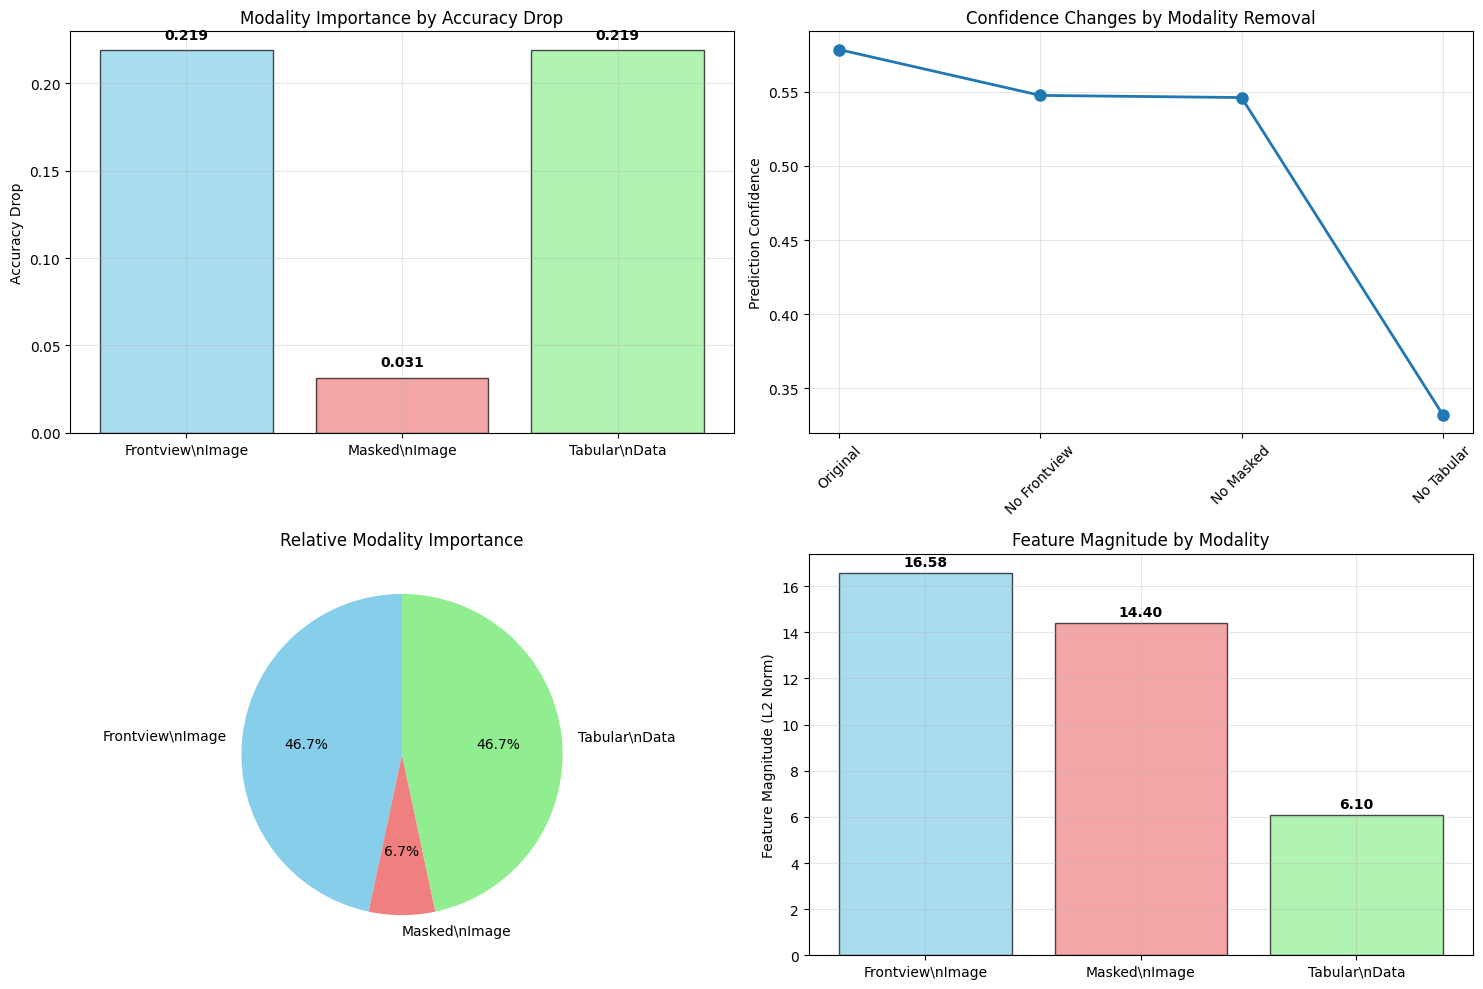

\n📋 Multimodal Fusion Analysis Summary:
  Original Accuracy: 0.656
  Original Confidence: 0.578
\n🔍 Importance by Accuracy Drop (higher = more important):
  Frontview Image: 0.219
  Masked Image: 0.031
  Tabular Data: 0.219
✅ Multimodal fusion analysis completed
\n4️⃣ MASK IMPACT ANALYSIS
--------------------------------------------------
🎭 Analyzing mask impact on predictions...


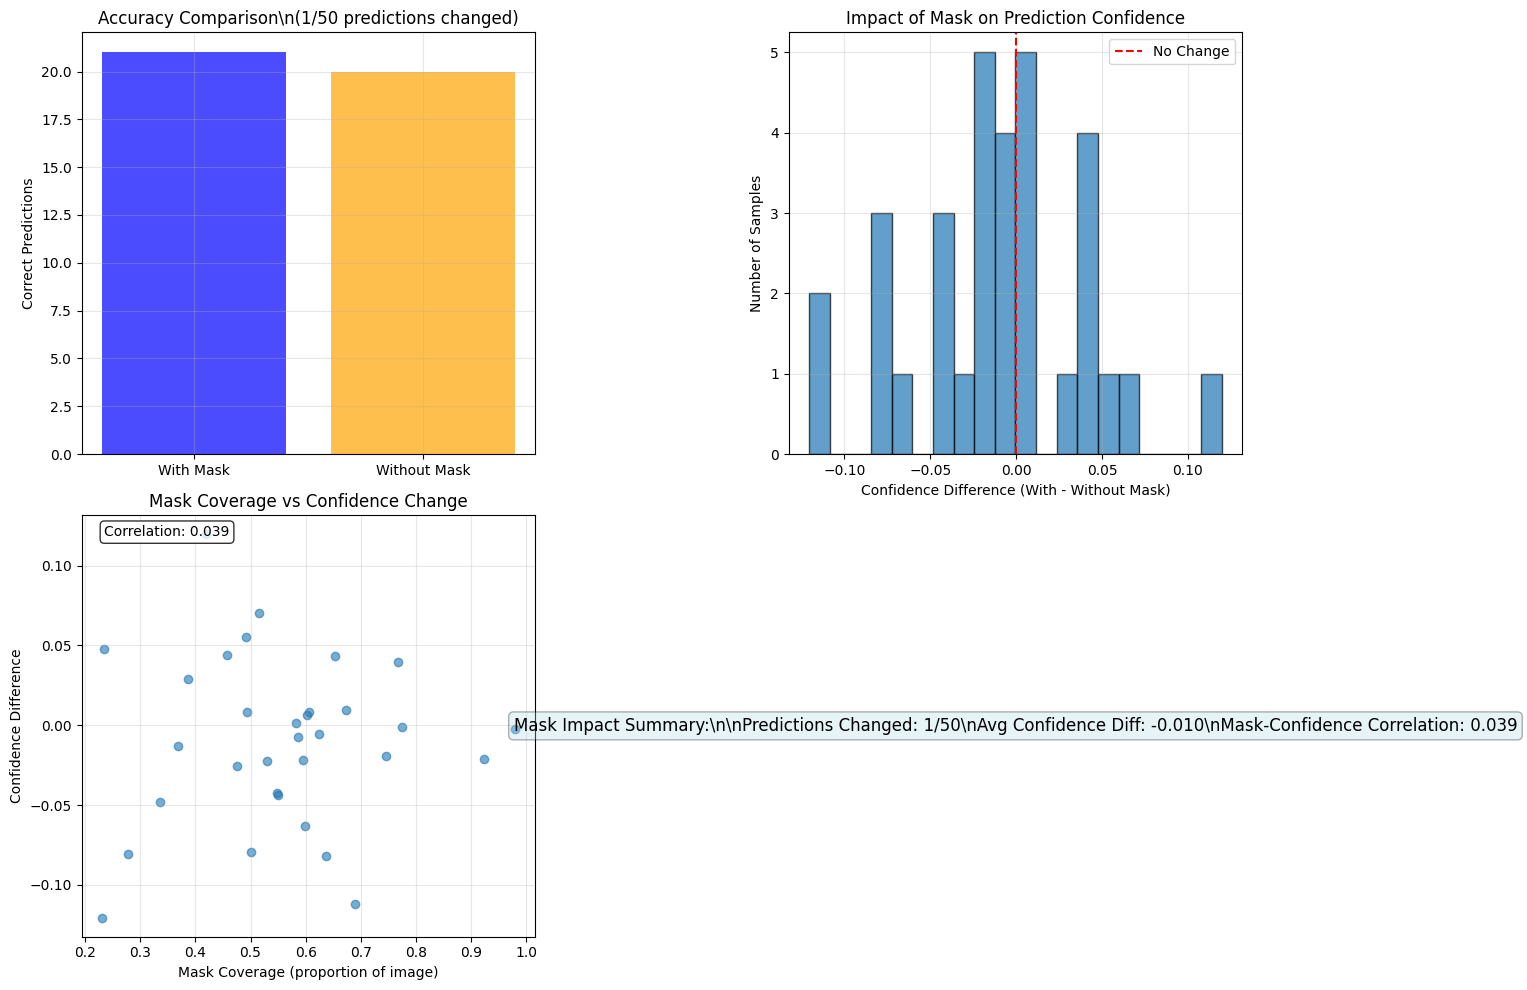

\n🎭 Mask Impact Summary:
  Predictions changed: 1/50 (2.0%)
  Average confidence difference: -0.010
  Mask coverage correlation: 0.039
✅ Mask impact analysis completed
\n============================================================
🎉 FEATURE IMPORTANCE ANALYSIS COMPLETE!
\n📊 KEY INSIGHTS SUMMARY:
------------------------------
🔝 Top 5 Most Important Tabular Features:
   1. Build Type Hoekwoning
   2. Build Type Tweeonder1Kap
   3. Build Type Appartement
   4. Build Type Tussen Of Geschakelde Woning
   5. Elongation
\n🏆 Most Important Modality: Frontview (drop: 0.219)
\n🎭 Mask Impact: 1 predictions changed
   Correlation with coverage: 0.039
\n💡 Use these insights to:
   • Focus on the most important tabular features
   • Understand model attention patterns in images
   • Optimize the multimodal fusion strategy
   • Improve mask generation and application


In [18]:
# --- Execute Feature Importance Analysis ---

print("🚀 Starting comprehensive feature importance analysis...")
print("=" * 60)

# Get sample data for analysis
print("📦 Preparing sample data...")
sample_batch = get_sample_batch(test_loader, batch_size=8)

if chosen_model == 'MultiMask' or chosen_model == 'MaskMultimodalWithPretrained':
    sample_images, sample_masks, sample_tabular, sample_labels = sample_batch
else:
    sample_images, _, sample_tabular, sample_labels = sample_batch
    sample_masks = None

print(f"✅ Sample batch prepared with {len(sample_images)} samples")
print("=" * 60)

# 1. Tabular Feature Importance Analysis
print("\\n1️⃣ TABULAR FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)
try:
    grad_importance, feature_names = analyze_tabular_feature_importance(
        final_model, test_loader, tabular_features, device, chosen_model, n_samples=50
    )
    print("✅ Tabular feature importance analysis completed")
except Exception as e:
    print(f"❌ Error in tabular analysis: {e}")

print("=" * 60)

# 2. Image Attention Visualization
print("\\n2️⃣ IMAGE ATTENTION VISUALIZATION")
print("-" * 50)
try:
    visualize_image_attention(
        final_model, sample_images, sample_masks, sample_tabular, 
        sample_labels, device, chosen_model, n_samples=4
    )
    print("✅ Image attention visualization completed")
except Exception as e:
    print(f"❌ Error in image analysis: {e}")

print("=" * 60)

# 3. Multimodal Fusion Analysis (only for MultiMask model)
if chosen_model == 'MultiMask' or chosen_model == 'MaskMultimodalWithPretrained':
    print("\\n3️⃣ MULTIMODAL FUSION ANALYSIS")
    print("-" * 50)
    try:
        fusion_results = analyze_multimodal_fusion(
            final_model, test_loader, device, chosen_model, n_samples=100
        )
        print("✅ Multimodal fusion analysis completed")
    except Exception as e:
        print(f"❌ Error in fusion analysis: {e}")
    
    print("=" * 60)
    
    # 4. Mask Impact Analysis
    print("\\n4️⃣ MASK IMPACT ANALYSIS")
    print("-" * 50)
    try:
        mask_results = analyze_mask_impact(
            final_model, test_loader, device, n_samples=50
        )
        print("✅ Mask impact analysis completed")
    except Exception as e:
        print(f"❌ Error in mask analysis: {e}")
else:
    print(f"\\n⚠️ Multimodal fusion and mask analysis skipped for {chosen_model} model")

print("\\n" + "=" * 60)
print("🎉 FEATURE IMPORTANCE ANALYSIS COMPLETE!")
print("=" * 60)

# Summary of key insights
print("\\n📊 KEY INSIGHTS SUMMARY:")
print("-" * 30)

if 'grad_importance' in locals():
    top_features = np.argsort(grad_importance)[-5:][::-1]
    print("🔝 Top 5 Most Important Tabular Features:")
    for i, idx in enumerate(top_features):
        print(f"   {i+1}. {feature_names[idx]}")

if chosen_model == 'MultiMask' or chosen_model == 'MaskMultimodalWithPretrained' and 'fusion_results' in locals():
    acc_drops = fusion_results['accuracy_drops']
    most_important = max(acc_drops, key=acc_drops.get)
    print(f"\\n🏆 Most Important Modality: {most_important.title()} (drop: {acc_drops[most_important]:.3f})")

if chosen_model == 'MultiMask' or chosen_model == 'MaskMultimodalWithPretrained' and 'mask_results' in locals():
    print(f"\\n🎭 Mask Impact: {mask_results['prediction_changes']} predictions changed")
    print(f"   Correlation with coverage: {mask_results['correlation']:.3f}")

print("\\n💡 Use these insights to:")
print("   • Focus on the most important tabular features")
print("   • Understand model attention patterns in images")
print("   • Optimize the multimodal fusion strategy")
print("   • Improve mask generation and application")